In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from statsmodels.regression.linear_model import WLS
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import statsmodels.stats.diagnostic as smsdia
from sklearn.metrics import mean_squared_error
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.graphics.regressionplots import plot_leverage_resid2
%matplotlib inline

## 1. Загрузка данных

In [2]:
data = pd.read_csv('data/hotel_data.csv', sep=';')

In [3]:
data.head()

,Hotel name,Rating,Stars,Distance to the sea,Distance to the downtown,Room area,Swimming pool,Price
0,Bonanova Park,7.7,2.0,7.0,5.0,16.0,0,63
1,Travelodge Barcelona Poblenou,7.9,1.0,0.5,2.0,15.0,0,83
2,Senator Barcelona Spa Hotel,7.8,4.0,5.0,3.0,21.0,1,91
3,Hotel Medicis,7.9,2.0,2.0,1.0,10.0,0,87
4,Paral-lel,8.4,2.0,0.5,1.0,19.0,0,102


### 1.1 Описание данных

In [4]:
data.describe()

,Rating,Stars,Distance to the sea,Distance to the downtown,Room area,Swimming pool,Price
count,208.000000,207.000000,208.000000,208.000000,207.000000,208.000000,208.000000
mean,7.980288,3.260870,2.585096,1.258173,18.483092,0.250000,129.754808
std,0.491125,0.841615,1.656875,1.168520,5.172599,0.434057,29.895025
min,6.400000,1.000000,0.000000,0.000000,8.000000,0.000000,63.000000
25%,7.700000,3.000000,1.500000,0.500000,15.000000,0.000000,107.000000
50%,8.000000,3.000000,2.500000,1.000000,18.000000,0.000000,126.000000
75%,8.300000,4.000000,3.000000,2.000000,21.000000,0.250000,151.250000
max,9.000000,4.000000,9.000000,5.000000,44.000000,1.000000,210.000000


Также посмотрим на медианы

In [5]:
data.median()

Rating                        8.0
Stars                         3.0
Distance to the sea           2.5
Distance to the downtown      1.0
Room area                    18.0
Swimming pool                 0.0
Price                       126.0
dtype: float64

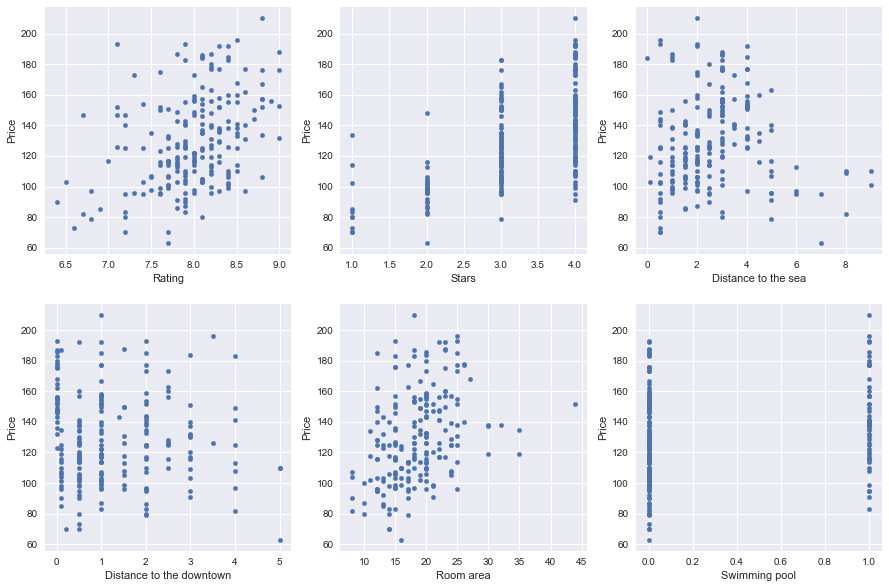

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for idx, feature in enumerate(data.columns[1:-1]):
    data.plot(feature, 'Price', subplots=True, kind='scatter', ax=axes[int(idx / 3), int(idx % 3)])

### 1.2 Проверка наличия пропусков

In [7]:
def checkNANs(dataframe):
    print("Есть ли пропуски в датафрейме?: ", dataframe.isnull().values.any())

In [8]:
checkNANs(data)

Есть ли пропуски в датафрейме?:  True


Найдем пропуски:

In [9]:
nan_indexes = data.isnull().any(axis=1)
data[nan_indexes]

,Hotel name,Rating,Stars,Distance to the sea,Distance to the downtown,Room area,Swimming pool,Price
6,Hotel Barbara,6.6,1.0,0.5,0.5,NaN,0,73
58,Holiday Inn Express Barcelona City 22,7.6,NaN,0.5,1.5,25.0,0,96


### 1.3 Заполнение пропусков

In [10]:
mean_dict = data.mean() # cacl mean
for key in mean_dict.keys(): # round values
    mean_dict[key] = int(mean_dict[key])

Округленные средние значения

In [11]:
mean_dict

Rating                        7.0
Stars                         3.0
Distance to the sea           2.0
Distance to the downtown      1.0
Room area                    18.0
Swimming pool                 0.0
Price                       129.0
dtype: float64

Заполняем средними

In [12]:
data = data.fillna(mean_dict)

Проверим заполнение пропусков средним значением:

In [13]:
data[nan_indexes]

,Hotel name,Rating,Stars,Distance to the sea,Distance to the downtown,Room area,Swimming pool,Price
6,Hotel Barbara,6.6,1.0,0.5,0.5,18.0,0,73
58,Holiday Inn Express Barcelona City 22,7.6,3.0,0.5,1.5,25.0,0,96


In [14]:
checkNANs(data)

Есть ли пропуски в датафрейме?:  False


## 2. Проверка данных

### 2.1 Построение корреляционной матрицы

In [15]:
data.corr()

,Rating,Stars,Distance to the sea,Distance to the downtown,Room area,Swimming pool,Price
Rating,1.000000,0.186994,-0.021557,-0.128974,0.191710,0.202255,0.405103
Stars,0.186994,1.000000,0.163200,0.177517,0.467148,0.298196,0.593109
Distance to the sea,-0.021557,0.163200,1.000000,0.333458,0.073053,0.054242,0.004539
Distance to the downtown,-0.128974,0.177517,0.333458,1.000000,0.147002,0.158823,-0.109614
Room area,0.191710,0.467148,0.073053,0.147002,1.000000,0.265290,0.362466
Swimming pool,0.202255,0.298196,0.054242,0.158823,0.265290,1.000000,0.253810
Price,0.405103,0.593109,0.004539,-0.109614,0.362466,0.253810,1.000000


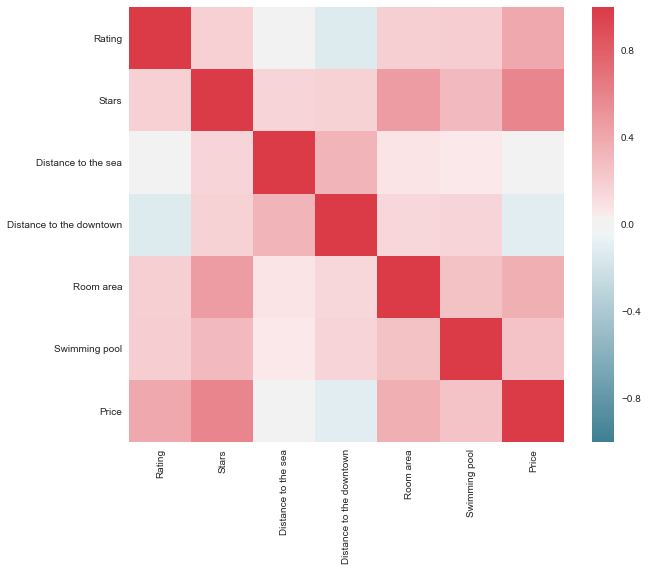

In [16]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

### 2.2 Удаление малоинформативных признаков

Как видно из корреляционной матрицы, зависимость между ценой и расстоянием до моря/центра города очень слабая (меньше 20%). <br>Поэтому, удалим эти признаки. 

In [17]:
# data = data.drop(['Distance to the sea'], axis = 1)

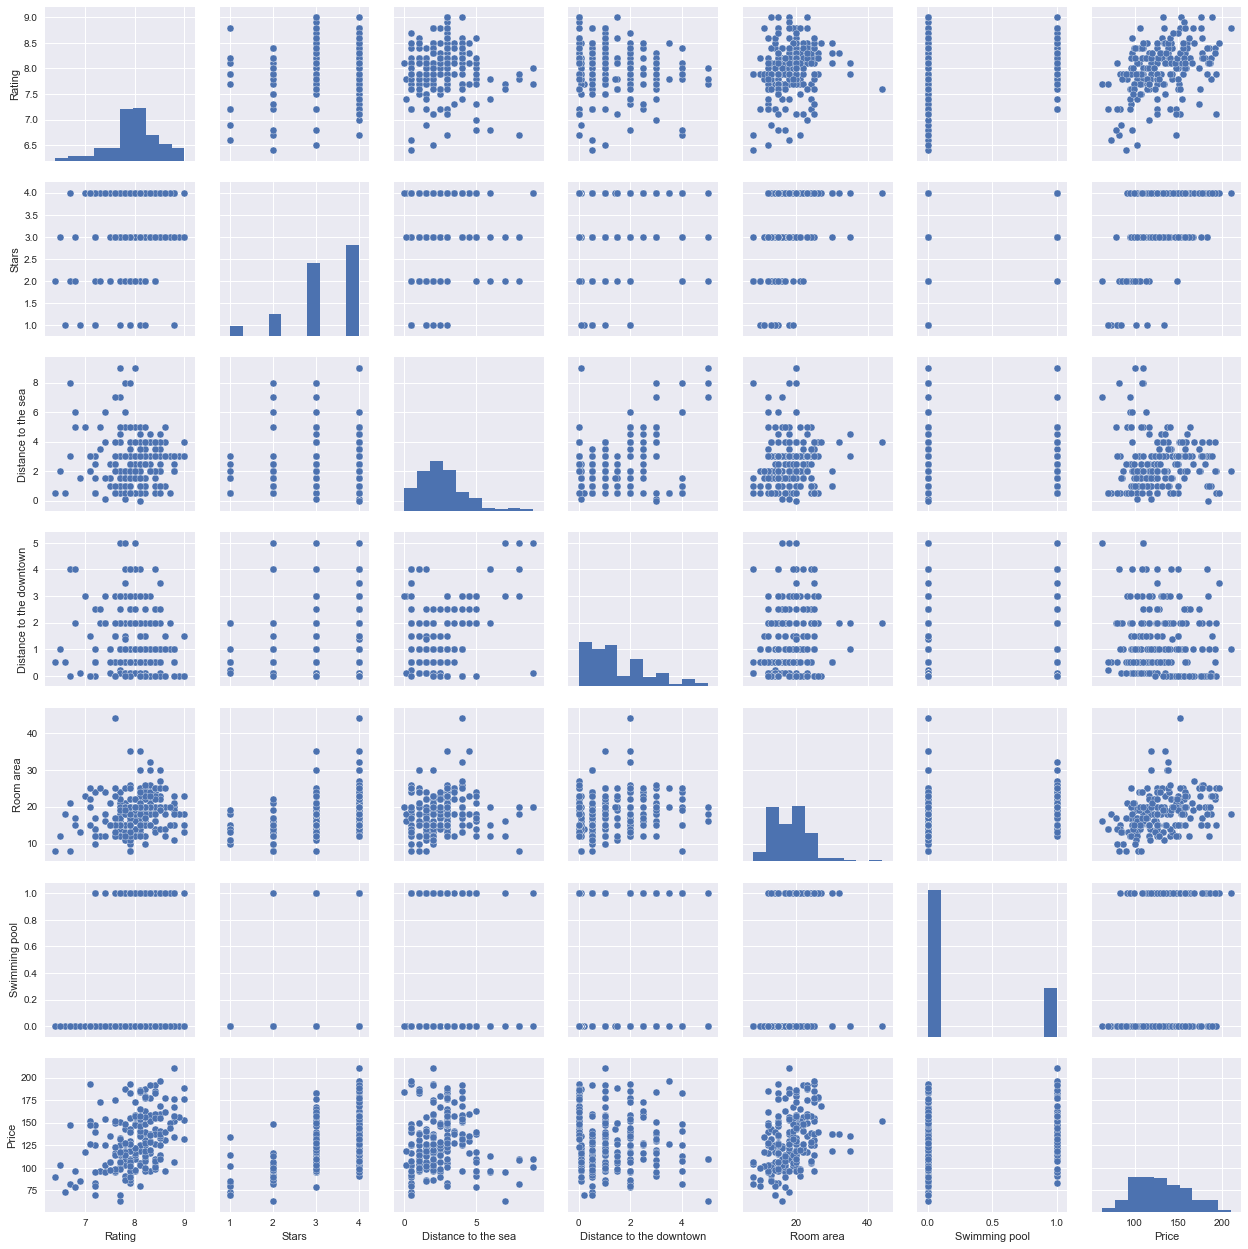

In [18]:
sns.pairplot(data)
plt.show()

## 3. Обучение модели

In [19]:
X_data = data.ix[:,1:].copy()

In [20]:
X_data = X_data.rename(columns = {'Distance to the sea':'Sea', 'Distance to the downtown':'Downtown', 'Room area':'Room', 'Swimming pool': 'Pool'})

In [21]:
results = smf.ols(formula='Price ~ Rating + Stars + Downtown + Sea + Room + Pool', data=X_data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     30.88
Date:                Tue, 16 May 2017   Prob (F-statistic):           3.78e-26
Time:                        00:27:35   Log-Likelihood:                -933.43
No. Observations:                 208   AIC:                             1881.
Df Residuals:                     201   BIC:                             1904.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -58.4340     25.853     -2.260      0.025      -109.412    -7.456
Rating        15.5797      3.271      4.763      0.000         9.129    22.030
Stars         18.7843      2.129      8.823      0.000        14.586    22.983
Downtown      -4.6748      1.431     -3.267      0.001        -7.496    -1.853
Sea           -0.4325      0.981     -0.441      0.660        -2.366     1.501
Room           0.4712      0.340      1.386      0.167        -0.199     1.142
Pool           3.6805      3.785      0.972      0.332        -3.783    11.144
==============================================================================
Omnibus:                        8.684   Durbin-Watson:                   1.146
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                9.025
Skew:                           0.510   Prob(JB):                       0.0110
Kurtosis:                       2.963   Cond. No.                         363.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
data = data.drop(['Distance to the sea'], axis = 1)
results = smf.ols(formula='Price ~ Rating + Stars + Downtown + Room + Pool', data=X_data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     37.16
Date:                Tue, 16 May 2017   Prob (F-statistic):           6.45e-27
Time:                        00:27:35   Log-Likelihood:                -933.53
No. Observations:                 208   AIC:                             1879.
Df Residuals:                     202   BIC:                             1899.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -58.9518     25.775     -2.287      0.023      -109.774    -8.129
Rating        15.5693      3.265      4.769      0.000         9.132    22.007
Stars         18.6768      2.111      8.848      0.000        14.515    22.839
Downtown      -4.8713      1.357     -3.589      0.000        -7.547    -2.195
Room           0.4749      0.339      1.400      0.163        -0.194     1.144
Pool           3.7277      3.776      0.987      0.325        -3.718    11.173
==============================================================================
Omnibus:                        9.214   Durbin-Watson:                   1.145
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.513
Skew:                           0.524   Prob(JB):                      0.00860
Kurtosis:                       3.037   Cond. No.                         360.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 3.1 Обучение МНК

In [23]:
X_data=X_data.rename(columns = {'Distance to the downtown':'Downtown', 'Room area':'Room', 'Swimming pool': 'Pool'})

In [24]:
results = smf.ols(formula='np.log(Price) ~ np.log(Rating) + np.log(Stars) + np.log(Downtown + 1) + np.log(Room) + np.log(Pool + 1)', data=X_data).fit()

In [25]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Price)   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     43.40
Date:                Tue, 16 May 2017   Prob (F-statistic):           2.93e-30
Time:                        00:27:35   Log-Likelihood:                 83.435
No. Observations:                 208   AIC:                            -154.9
Df Residuals:                     202   BIC:                            -134.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                2.2698      0.395      5.752      0.000         1.492     3.048
np.log(Rating)           0.9323      0.193      4.842      0.000         0.553     1.312
np.log(Stars)            0.3650      0.039      9.320      0.000         0.288     0.442
np.log(Downtown + 1)    -0.1010      0.024     -4.204      0.000        -0.148    -0.054
np.log(Room)             0.0983      0.048      2.058      0.041         0.004     0.193
np.log(Pool + 1)         0.0406      0.041      0.995      0.321        -0.040     0.121
==============================================================================
Omnibus:                        2.703   Durbin-Watson:                   1.160
Prob(Omnibus):                  0.259   Jarque-Bera (JB):                2.761
Skew:                           0.253   Prob(JB):                        0.251
Kurtosis:                       2.749   Cond. No.                         150.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 4.2 Оценка качества

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

V = X_data.copy()
V = V.drop(['Sea', 'Price'], axis = 1)
column_names = V.columns

for i in range(0, 5):
    VIF = variance_inflation_factor(V.values, i)
    print ('VIF for', column_names[i], ':', VIF)

VIF for Rating : 21.6628154767
VIF for Stars : 21.9471970326
VIF for Downtown : 2.25971910267
VIF for Room : 18.460130998
VIF for Pool : 1.48435520949


In [27]:
X_data

,Rating,Stars,Sea,Downtown,Room,Pool,Price
0,7.7,2.0,7.0,5.0,16.0,0,63
1,7.9,1.0,0.5,2.0,15.0,0,83
2,7.8,4.0,5.0,3.0,21.0,1,91
3,7.9,2.0,2.0,1.0,10.0,0,87
4,8.4,2.0,0.5,1.0,19.0,0,102
5,7.2,2.0,3.0,1.0,14.0,1,83
6,6.6,1.0,0.5,0.5,18.0,0,73
7,7.3,2.0,5.0,2.0,12.0,0,96
8,6.4,2.0,0.5,0.5,8.0,0,90
9,7.9,2.0,0.5,0.5,13.0,0,92


In [28]:
C_model = smf.ols(formula='np.log(Price) ~ Rating + C(Stars) + np.log(Downtown + 1) + np.log(Room) + C(Pool)', data=X_data).fit()
C_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Price)   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     34.10
Date:                Tue, 16 May 2017   Prob (F-statistic):           5.39e-31
Time:                        00:27:36   Log-Likelihood:                 89.255
No. Observations:                 208   AIC:                            -162.5
Df Residuals:                     200   BIC:                            -135.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                3.3800      0.215     15.757      0.000         2.957     3.803
C(Stars)[T.2.0]          0.0990      0.061      1.624      0.106        -0.021     0.219
C(Stars)[T.3.0]          0.2870      0.056      5.166      0.000         0.177     0.397
C(Stars)[T.4.0]          0.4437      0.057      7.743      0.000         0.331     0.557
C(Pool)[T.1]             0.0184      0.028      0.660      0.510        -0.036     0.073
Rating                   0.1271      0.024      5.238      0.000         0.079     0.175
np.log(Downtown + 1)    -0.1021      0.024     -4.334      0.000        -0.149    -0.056
np.log(Room)             0.0642      0.048      1.340      0.182        -0.030     0.159
==============================================================================
Omnibus:                        1.567   Durbin-Watson:                   1.199
Prob(Omnibus):                  0.457   Jarque-Bera (JB):                1.647
Skew:                           0.198   Prob(JB):                        0.439
Kurtosis:                       2.819   Cond. No.                         168.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

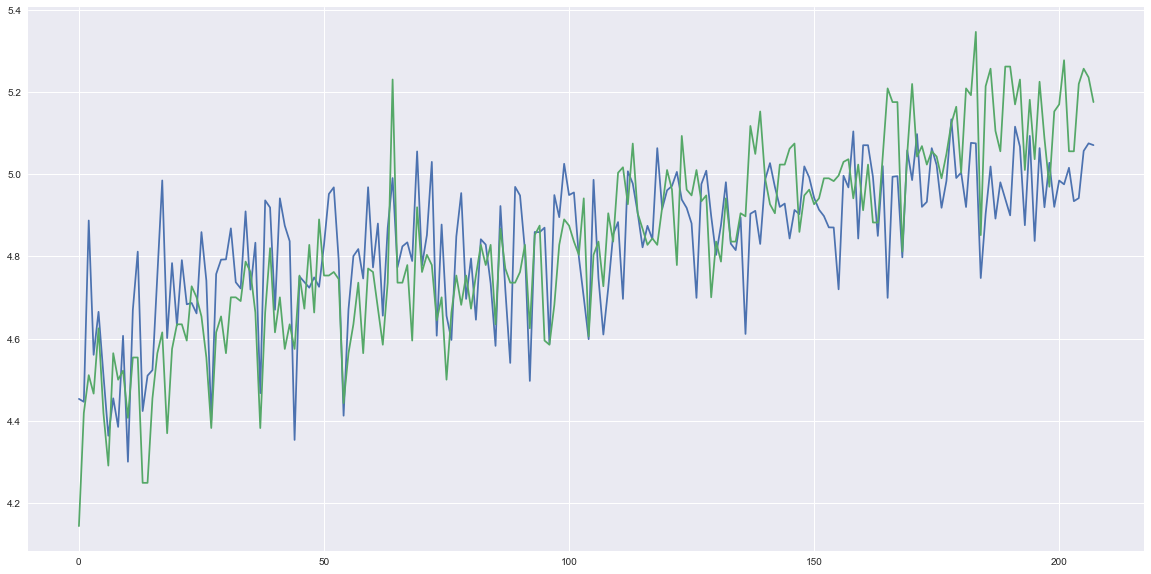

In [29]:
X_plot = np.linspace(0,1,100)
plt.figure(figsize=(20,10))
plt.plot(C_model.fittedvalues)
plt.plot(np.log(X_data['Price']))
plt.show()

Тестирование мультиколлинеарности

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

V = X_data.copy()
V = V.drop(['Sea', 'Price'], axis = 1)
column_names = ['Stars[T.2.0]', 'Stars[T.3.0]', 'Stars[T.4.0]', 'Pool[T.1]', 'Rating', 'Downtown', 'Room']

for i in range(1, 8):
    VIF = variance_inflation_factor(C_model.model.exog, i)
    print ('VIF for', column_names[i-1], ':', VIF)

VIF for Stars[T.2.0] : 2.9483555525
VIF for Stars[T.3.0] : 5.8298434945
VIF for Stars[T.4.0] : 6.58501898338
VIF for Pool[T.1] : 1.16816785795
VIF for Rating : 1.13931238254
VIF for Downtown : 1.08651200755
VIF for Room : 1.44269081673


In [31]:
new_table = pd.DataFrame(data=C_model.model.exog)
new_table = new_table.drop([0, 3], axis = 1)

In [32]:
column_names = ['Stars[T.2.0]', 'Stars[T.3.0]', 'Pool[T.1]', 'Rating', 'Downtown', 'Room']

for i in range(0,6):
    VIF = variance_inflation_factor(new_table.values, i)
    print ('VIF for', column_names[i], ':', VIF)

VIF for Stars[T.2.0] : 1.3586441129
VIF for Stars[T.3.0] : 1.87080843466
VIF for Pool[T.1] : 1.46545120266
VIF for Rating : 115.565015664
VIF for Downtown : 3.13857084661
VIF for Room : 114.726552038


In [33]:
new_table = new_table.drop([5], axis = 1)

In [34]:
column_names = ['Stars[T.2.0]', 'Stars[T.3.0]', 'Pool[T.1]', 'Downtown', 'Room']

for i in range(0,5):
    VIF = variance_inflation_factor(new_table.values, i)
    print ('VIF for', column_names[i], ':', VIF)

VIF for Stars[T.2.0] : 1.20737988539
VIF for Stars[T.3.0] : 1.72892697076
VIF for Pool[T.1] : 1.46544979783
VIF for Downtown : 3.11042025419
VIF for Room : 4.67894006177


In [35]:
new_table = new_table.assign(Price = X_data['Price'])
new_table

,1,2,4,6,7,Price
0,1.0,0.0,0.0,1.791759,2.772589,63
1,0.0,0.0,0.0,1.098612,2.708050,83
2,0.0,0.0,1.0,1.386294,3.044522,91
3,1.0,0.0,0.0,0.693147,2.302585,87
4,1.0,0.0,0.0,0.693147,2.944439,102
5,1.0,0.0,1.0,0.693147,2.639057,83
6,0.0,0.0,0.0,0.405465,2.890372,73
7,1.0,0.0,0.0,1.098612,2.484907,96
8,1.0,0.0,0.0,0.405465,2.079442,90
9,1.0,0.0,0.0,0.405465,2.564949,92


In [36]:
column_names = ['Stars2', 'Stars3', 'Pool', 'Downtown', 'Room', 'Price']
new_table.columns = column_names

In [37]:
new_C_model = smf.ols(formula='np.log(Price) ~ Stars2 + Stars3 + np.log(Downtown + 1) + np.log(Room) + Pool', data=new_table).fit()
new_C_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Price)   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     20.09
Date:                Tue, 16 May 2017   Prob (F-statistic):           3.01e-16
Time:                        00:27:36   Log-Likelihood:                 49.547
No. Observations:                 208   AIC:                            -87.09
Df Residuals:                     202   BIC:                            -67.07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                4.3255      0.165     26.291      0.000         4.001     4.650
Stars2                  -0.2570      0.049     -5.205      0.000        -0.354    -0.160
Stars3                  -0.0822      0.030     -2.751      0.006        -0.141    -0.023
np.log(Downtown + 1)    -0.1931      0.045     -4.258      0.000        -0.282    -0.104
np.log(Room)             0.6158      0.154      4.009      0.000         0.313     0.919
Pool                     0.0697      0.033      2.128      0.035         0.005     0.134
==============================================================================
Omnibus:                        9.298   Durbin-Watson:                   0.998
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               10.371
Skew:                          -0.388   Prob(JB):                      0.00560
Kurtosis:                       3.770   Cond. No.                         27.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Тестирование автокорреляции

In [38]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
abg = acorr_breusch_godfrey(results, 1)
print(abg)

ImportError: cannot import name 'acorr_breusch_godfrey'

Тестирование гетероскедастичности

In [39]:
def testModel(results, name, y_true, y_pred, resid):
    print('Params for ' + name + ':')
    print(results.params)
    print('\n')
    
    print('MSE ' + name + ':', mean_squared_error(y_true, y_pred))
    print('\n')
    
    print('Heteroscedasticity test:')
    hb = smsdia.het_breushpagan(resid, results.model.exog)
    print('LM: ', hb[0])
    print('LM_pvalue: ', hb[1])
    print('fvalue: ', hb[2])
    print('f_value: ', hb[3])
    print('\n')
    
    name = ['F statistic', 'p-value']
    test = sms.het_goldfeldquandt(results.resid, results.model.exog)
    print(lzip(name, test))
    
    print('\n')
    print('Jarque-Bera test:')
    name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
    test = sms.jarque_bera(resid)
    print(lzip(name, test))
    
    print('\n')
    print('Multicollinearity: condition number')
    print(np.linalg.cond(results.model.exog))
    
    try:
        fig, ax = plt.subplots(figsize=(8,6))
        fig = plot_leverage_resid2(results, ax = ax)
    except Exception:
        print('\n')
        # ignored

Params for OLS:
Intercept               2.269844
np.log(Rating)          0.932265
np.log(Stars)           0.364988
np.log(Downtown + 1)   -0.100990
np.log(Room)            0.098315
np.log(Pool + 1)        0.040560
dtype: float64


MSE OLS: 0.0262487999714


Heteroscedasticity test:
LM:  3.17744886926
LM_pvalue:  0.672649939667
fvalue:  0.626732425748
f_value:  0.67955138318


[('F statistic', 1.2722045992053388), ('p-value', 0.11757532494212145)]


Jarque-Bera test:
[('Jarque-Bera', 2.760777055101415), ('Chi^2 two-tail prob.', 0.2514808268466181), ('Skew', 0.2528790822194737), ('Kurtosis', 2.7494807836334814)]


Multicollinearity: condition number
150.471342876


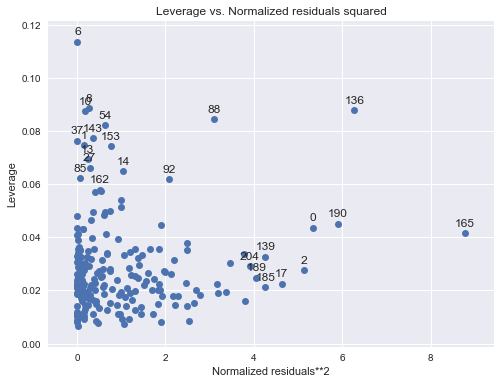

In [40]:
testModel(results, 'OLS', np.log(X_data['Price'].values), results.fittedvalues, results.resid.values)

Корректируем гетероскедастичность 

In [41]:
def fgls(model):
    return sm.WLS(model.endog, model.exog,
                  1 / np.exp(sm.OLS(np.log(model.fit().resid ** 2), model.exog).fit().predict()))

In [42]:
wls_results = fgls(C_model.model).fit()

In [43]:
wls_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.580
Model:                            WLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     39.54
Date:                Tue, 16 May 2017   Prob (F-statistic):           1.54e-34
Time:                        00:28:22   Log-Likelihood:                 91.646
No. Observations:                 208   AIC:                            -167.3
Df Residuals:                     200   BIC:                            -140.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.4814      0.196     17.805      0.000         3.096     3.867
x1             0.1300      0.062      2.109      0.036         0.008     0.252
x2             0.3114      0.060      5.208      0.000         0.193     0.429
x3             0.4823      0.061      7.888      0.000         0.362     0.603
x4             0.0082      0.028      0.293      0.770        -0.047     0.063
x5             0.1119      0.022      4.992      0.000         0.068     0.156
x6            -0.1161      0.023     -5.011      0.000        -0.162    -0.070
x7             0.0643      0.045      1.440      0.151        -0.024     0.152
==============================================================================
Omnibus:                        0.950   Durbin-Watson:                   1.227
Prob(Omnibus):                  0.622   Jarque-Bera (JB):                1.048
Skew:                           0.151   Prob(JB):                        0.592
Kurtosis:                       2.828   Cond. No.                         158.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

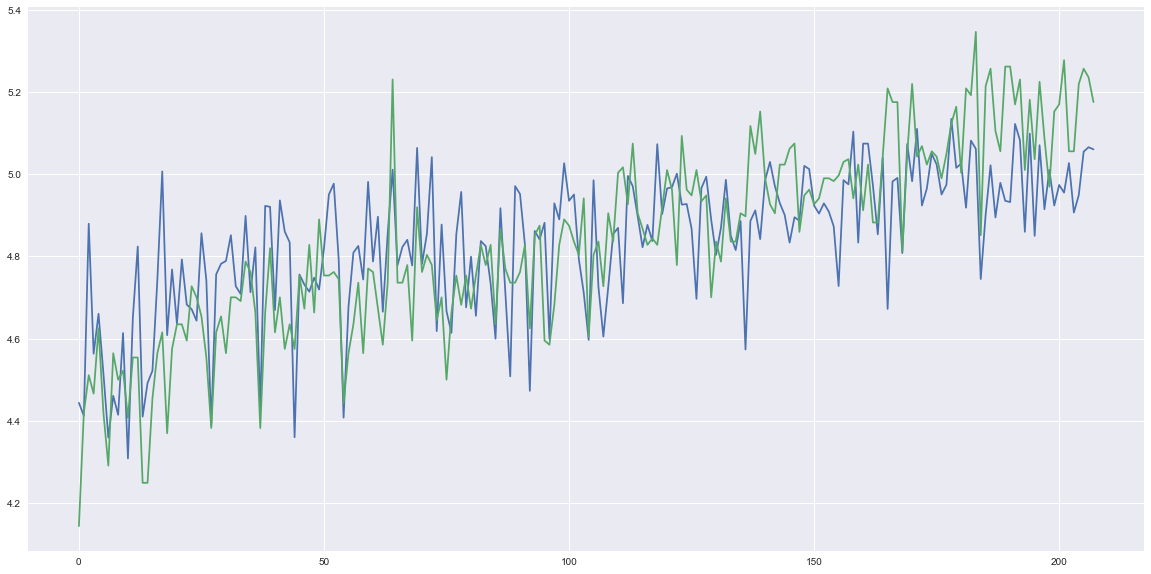

In [44]:
X_plot = np.linspace(0,1,100)
plt.figure(figsize=(20,10))
plt.plot(wls_results.fittedvalues)
plt.plot(np.log(X_data['Price']))
plt.show()